## setup

In [1]:
! pip install tensorflow numpy matplotlib torch torchvision pandas scikit-learn opencv-python

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob

## custom loss model

In [2]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import sklearn
import sklearn.metrics
from PIL import Image



2025-07-04 21:37:13.423772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-04 21:37:13.577487: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-04 21:37:13.602020: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-04 21:37:13.602033: I tensorflow/compiler

In [3]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(128, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same', name='prediction')(x)  # Output 3 channels

    model = Model(
        inputs=[x_ref_input, eta_exp_input],
        outputs={"prediction": x, "x_ref_passthrough": x_ref_input}
    )

    # Return both the prediction and the input x_ref (as passthrough)
    #model = Model(inputs=[x_ref_input, eta_exp_input], outputs=[x, x_ref_input])

    # model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)
    return model


In [4]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

class IntersectionOverlayCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_ref_val, eta_exp_val, x_ren_val, save_dir='overlay_outputs_50_epochs', interval=1):
        super().__init__()
        self.x_ref_val = x_ref_val
        self.eta_exp_val = eta_exp_val
        self.x_ren_val = x_ren_val
        self.interval = interval
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval != 0:
            return

        output_dict = self.model.predict([self.x_ref_val, self.eta_exp_val])
        preds = output_dict["prediction"]


        # Compute intersection (where rendered and reference are nearly equal)
        intersection_mask = np.isclose(self.x_ren_val, self.x_ref_val, atol=1e-2)

        # Overlay: only keep intersecting pixels in prediction
        overlay_preds = np.where(intersection_mask, self.x_ref_val, preds)
        #overlay_preds = np.where(intersection_mask, preds, 0.0)

        # Visualize or save first few samples
        num_samples = min(3, len(preds))
        for i in range(num_samples):
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            axes[0].imshow(self.x_ref_val[i])
            axes[0].set_title("x_ref")
            axes[1].imshow(self.x_ren_val[i])
            axes[1].set_title("x_ren")
            axes[2].imshow(preds[i])
            axes[2].set_title("prediction")
            axes[3].imshow(overlay_preds[i])
            axes[3].set_title("pred ∩ intersection")
            for ax in axes:
                ax.axis("off")

            plt.tight_layout()
            plt.savefig(os.path.join(self.save_dir, f"epoch_{epoch+1}_sample_{i+1}.png"))
            plt.close()


def masked_mse_only_on_diff(y_true, y_pred):
    # `y_pred` is just the output from 'prediction'
    # we will pull `x_ref` from the model's second output via `add_loss`

    # Use Keras backend to store global reference
    x_ref_tensor = tf.keras.backend.get_value(tf.keras.backend.learning_phase())  # placeholder
    raise NotImplementedError("You can't access the other output here directly")

# This is just to show that Keras doesn't allow cross-output access in a pure loss function
# So we use a custom training step instead — see next


class CustomModel(tf.keras.Model):
    def train_step(self, data):
        (x_ref, eta_exp), y_true = data

        with tf.GradientTape() as tape:
            outputs = self([x_ref, eta_exp], training=True)
            y_pred = outputs["prediction"]
            x_ref_passthrough = outputs["x_ref_passthrough"]

            # Calculate intersection mask
            epsilon = 1e-2
            mask = tf.cast(tf.abs(y_true - x_ref_passthrough) > epsilon, tf.float32)
            sq_diff = tf.square(y_true - y_pred)
            masked_sq_diff = sq_diff * mask
            loss = tf.reduce_sum(masked_sq_diff) / (tf.reduce_sum(mask) + 1e-8)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {"loss": loss}


def masked_mse_intersection_loss(y_true, y_pred):
    y_pred_img, x_ref = y_pred  # unpack model outputs
    x_ren = y_true  # the true rendered image

    epsilon = 1e-2
    mask = tf.abs(x_ren - x_ref) > epsilon
    mask = tf.cast(mask, tf.float32)

    sq_diff = tf.square(x_ren - y_pred_img)
    masked_sq_diff = sq_diff * mask
    denom = tf.reduce_sum(mask) + 1e-8

    return tf.reduce_sum(masked_sq_diff) / denom


def wrapper_loss(y_true, y_pred_outputs):
    return masked_mse_intersection_loss(y_true, y_pred_outputs)



# def masked_mse_outside_intersection(x_ref, x_ren, epsilon=1e-2):
#     def loss_fn(y_true, y_pred):
#         # Create a mask: where rendered and reference are NOT approximately equal
#         mask = tf.math.greater(tf.abs(x_ren - x_ref), epsilon)  # shape: (N, H, W, C)
#         mask = tf.cast(mask, tf.float32)

#         # Compute squared difference
#         sq_diff = tf.square(y_true - y_pred)

#         # Apply mask
#         masked_sq_diff = sq_diff * mask

#         # Avoid dividing by zero
#         denom = tf.reduce_sum(mask) + 1e-8

#         return tf.reduce_sum(masked_sq_diff) / denom  # Mean over masked elements
#     return loss_fn


In [6]:
base_model = build_simple_dtn(input_shape=(500, 500, 3))

model = CustomModel(inputs=base_model.inputs, outputs=base_model.output)

# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)
# model = build_simple_dtn(input_shape=(500, 500, 3))


model.compile(optimizer='adam', metrics=['accuracy'])
# Uncomment the following line to use a standard MSE loss instead
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Use a small validation set to visualize overlays
callback = IntersectionOverlayCallback(
    x_ref_val=x_ref[1025:], 
    eta_exp_val=eta_exp[1025:], 
    x_ren_val=x_ren[1025:], 
    save_dir='overlay_outputs_50_epochs', 
    interval=1  # every epoch
)


history = model.fit(
    [x_ref[:1025], eta_exp[:1025]],
    x_ren[:1025],
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[callback]
)
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
        
# early stopping disable for structure 4

2025-07-04 21:37:24.189682: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-04 21:37:24.189941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-04 21:37:24.190007: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-04 21:37:24.190054: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared o

Epoch 1/50
58/58 [==============================] - 237s 4s/step - loss: 0.0367 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.0366 - val_x_ref_accuracy: 0.9853
Epoch 2/50
58/58 [==============================] - 236s 4s/step - loss: 0.0111 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.0256 - val_x_ref_accuracy: 0.9853
Epoch 3/50
58/58 [==============================] - 234s 4s/step - loss: 0.0074 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.9721 - val_x_ref_accuracy: 0.9853
Epoch 4/50
58/58 [==============================] - 235s 4s/step - loss: 0.0078 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.0302 - val_x_ref_accuracy: 0.9853
Epoch 5/50
58/58 [==============================] - 234s 4s/step - loss: 0.0067 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.9782 - val_x_ref_accuracy: 0.9853
Epoch 6/50
58/58 [==============================] - 235s 4s/step - loss: 0.0057 - val_loss: 0.0000e+00 - val_prediction_accuracy: 0.9739 - val_x_ref_accuracy: 0.9853
Epoc

#### Validation on val_dataset

In [7]:
print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')
print(val_x_ref.shape)

Loading validation datasets...
(75, 500, 500, 3)


In [8]:
# Predict
preds = model.predict([val_x_ref, val_eta_exp])['prediction']

# Compute intersection (where rendered and reference are nearly equal)
intersection_mask = np.isclose(val_x_ren, val_x_ref, atol=1e-2)

# Overlay: only keep intersecting pixels in prediction
overlay_preds = np.where(intersection_mask, val_x_ref, preds)
# overlay_preds = np.where(intersection_mask, preds, 0.0)

avg_mse = sklearn.metrics.mean_squared_error(val_x_ren.ravel(), overlay_preds.ravel())


print("Average MSE: ", avg_mse)  

3/3 [==============================] - 5s 2s/step
Average MSE:  0.0003749294


1/1 [==============================] - 0s 383ms/step


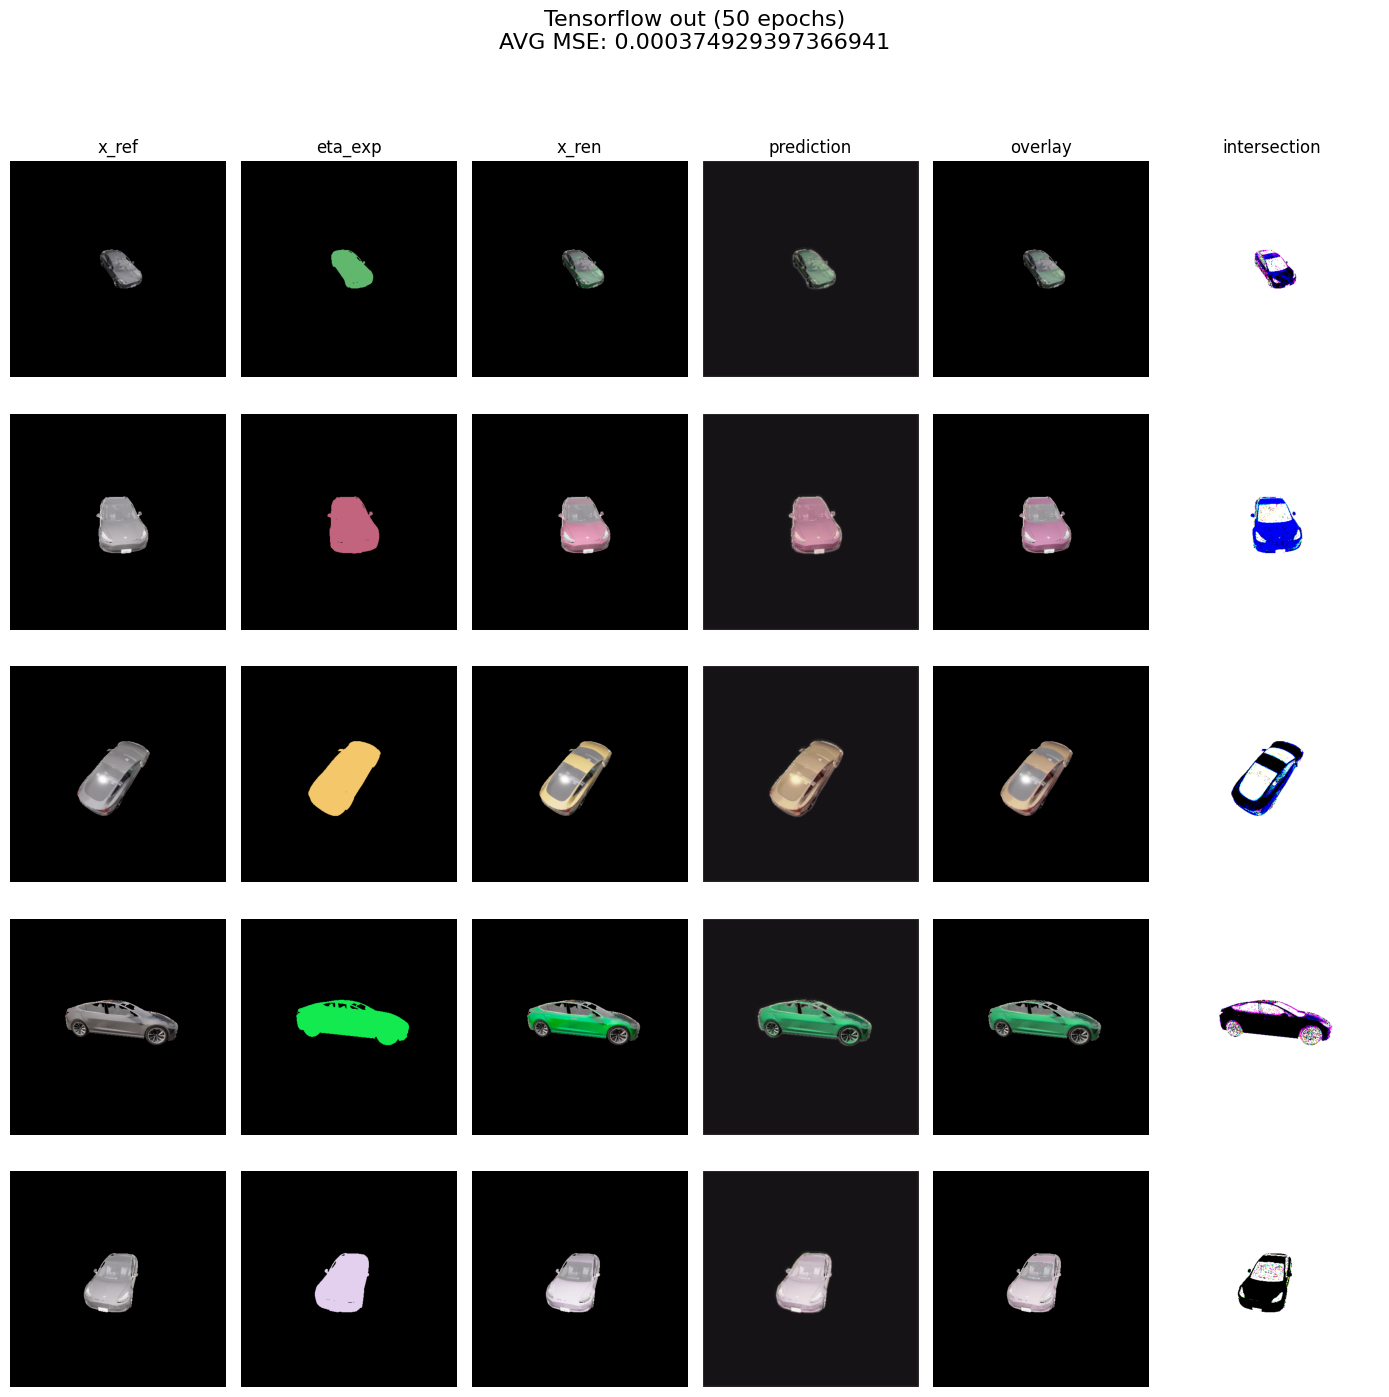

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])['prediction']

intersection_mask = np.isclose(x_ren[1025:], x_ref[1025:], atol=1e-2)
overlay_preds = np.where(intersection_mask, x_ref[1025:], preds)

num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction", "overlay", "intersection"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ref[i+1025],
        eta_exp[i+1025],
        x_ren[i+1025],
        preds[i],
        overlay_preds[i],
        intersection_mask[i].astype(float)  # Show mask as image
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), cmap='gray' if j == 5 else None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f"Tensorflow out (50 epochs)\nAVG MSE: {avg_mse}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## model (without custom loss)

In [2]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import sklearn
import sklearn.metrics
from PIL import Image



2025-07-05 07:57:16.443266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-05 07:57:16.593928: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 07:57:16.618273: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-05 07:57:16.618280: I tensorflow/compiler

In [3]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(128, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(64, (4, 4), activation='relu', padding='same')(x)
    x = Conv2D(32, (4, 4), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same', name='prediction')(x)  # Output 3 channels

    # Create the model
    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)

    return model


In [4]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

class IntersectionOverlayCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_ref_val, eta_exp_val, x_ren_val, save_dir='overlay_outputs_50_epochs_wo_custom_loss', interval=1):
        super().__init__()
        self.x_ref_val = x_ref_val
        self.eta_exp_val = eta_exp_val
        self.x_ren_val = x_ren_val
        self.interval = interval
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval != 0:
            return

        preds = self.model.predict([self.x_ref_val, self.eta_exp_val])


        # Compute intersection (where rendered and reference are nearly equal)
        intersection_mask = np.isclose(self.x_ren_val, self.x_ref_val, atol=1e-2)

        # Overlay: only keep intersecting pixels in prediction
        overlay_preds = np.where(intersection_mask, self.x_ref_val, preds)
        #overlay_preds = np.where(intersection_mask, preds, 0.0)

        # Visualize or save first few samples
        num_samples = min(3, len(preds))
        for i in range(num_samples):
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            axes[0].imshow(self.x_ref_val[i])
            axes[0].set_title("x_ref")
            axes[1].imshow(self.x_ren_val[i])
            axes[1].set_title("x_ren")
            axes[2].imshow(preds[i])
            axes[2].set_title("prediction")
            axes[3].imshow(overlay_preds[i])
            axes[3].set_title("pred ∩ intersection")
            for ax in axes:
                ax.axis("off")

            plt.tight_layout()
            plt.savefig(os.path.join(self.save_dir, f"epoch_{epoch+1}_sample_{i+1}.png"))
            plt.close()

In [6]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)
model = build_simple_dtn(input_shape=(500, 500, 3))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Use a small validation set to visualize overlays
callback = IntersectionOverlayCallback(
    x_ref_val=x_ref[1025:], 
    eta_exp_val=eta_exp[1025:], 
    x_ren_val=x_ren[1025:], 
    save_dir='overlay_outputs_50_epochs_wo_custom_loss', 
    interval=1  # every epoch
)


history = model.fit(
    [x_ref[:1025], eta_exp[:1025]],
    x_ren[:1025],
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    callbacks=[callback]
)
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
        
# early stopping disable for structure 4

2025-07-05 07:57:26.639427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-05 07:57:26.639710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-05 07:57:26.639775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64
2025-07-05 07:57:26.639819: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared o

Epoch 1/50
58/58 [==============================] - 237s 4s/step - loss: 0.0282 - accuracy: 0.1477 - val_loss: 0.0016 - val_accuracy: 0.0094
Epoch 2/50
58/58 [==============================] - 236s 4s/step - loss: 0.0012 - accuracy: 0.0149 - val_loss: 0.0014 - val_accuracy: 0.0130
Epoch 3/50
58/58 [==============================] - 235s 4s/step - loss: 9.9138e-04 - accuracy: 0.0167 - val_loss: 9.5618e-04 - val_accuracy: 0.0174
Epoch 4/50
58/58 [==============================] - 236s 4s/step - loss: 8.0443e-04 - accuracy: 0.0204 - val_loss: 8.3375e-04 - val_accuracy: 0.0236
Epoch 5/50
58/58 [==============================] - 236s 4s/step - loss: 5.8110e-04 - accuracy: 0.0246 - val_loss: 6.1700e-04 - val_accuracy: 0.0226
Epoch 6/50
58/58 [==============================] - 235s 4s/step - loss: 4.1606e-04 - accuracy: 0.0277 - val_loss: 4.9549e-04 - val_accuracy: 0.0269
Epoch 7/50
58/58 [==============================] - 236s 4s/step - loss: 3.8277e-04 - accuracy: 0.0291 - val_loss: 4.3124e

#### Validation on val_dataset

In [7]:
print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')
print(val_x_ref.shape)

Loading validation datasets...
(75, 500, 500, 3)


In [8]:
# Predict
preds = model.predict([val_x_ref, val_eta_exp])
# Compute intersection (where rendered and reference are nearly equal)
intersection_mask = np.isclose(val_x_ren, val_x_ref, atol=1e-2)

# Overlay: only keep intersecting pixels in prediction
overlay_preds = np.where(intersection_mask, val_x_ref, preds)
# overlay_preds = np.where(intersection_mask, preds, 0.0)

avg_mse = sklearn.metrics.mean_squared_error(val_x_ren.ravel(), overlay_preds.ravel())


print("Average MSE: ", avg_mse)  

3/3 [==============================] - 5s 2s/step
Average MSE:  0.00029292263


1/1 [==============================] - 0s 382ms/step


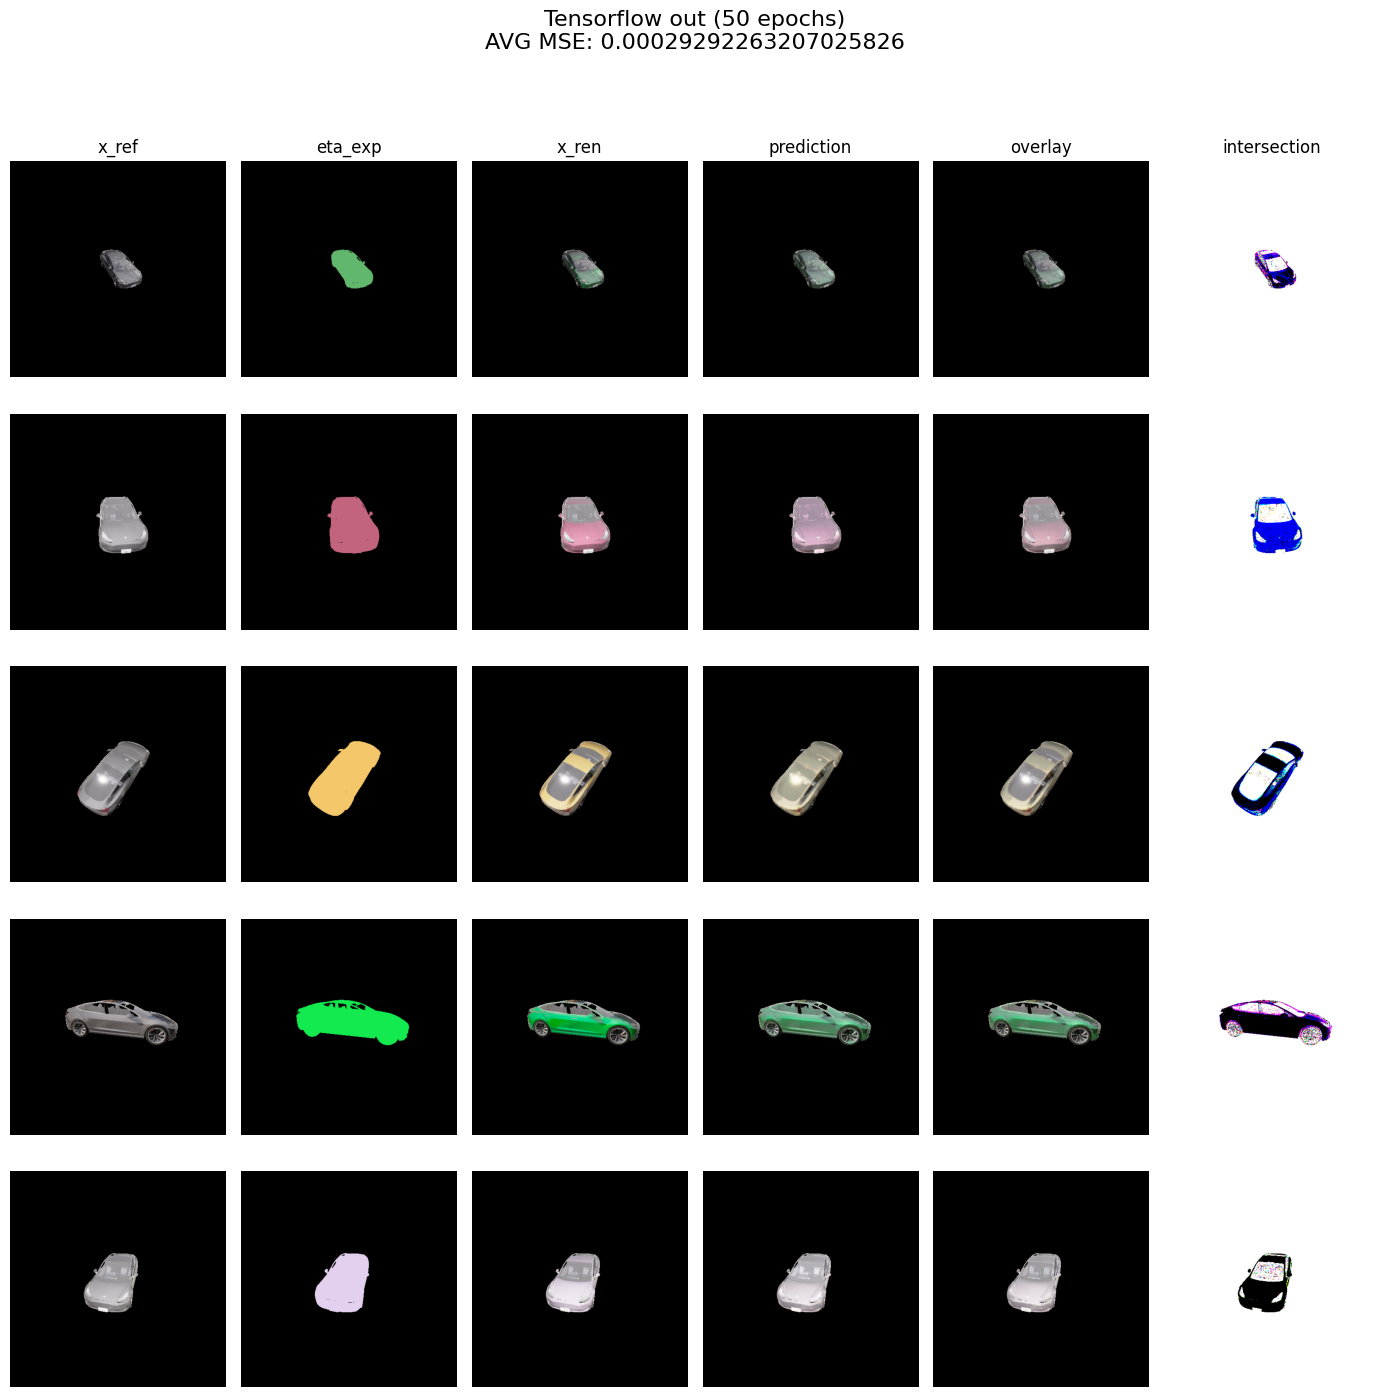

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])

intersection_mask = np.isclose(x_ren[1025:], x_ref[1025:], atol=1e-2)
overlay_preds = np.where(intersection_mask, x_ref[1025:], preds)

num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction", "overlay", "intersection"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ref[i+1025],
        eta_exp[i+1025],
        x_ren[i+1025],
        preds[i],
        overlay_preds[i],
        intersection_mask[i].astype(float)  # Show mask as image
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), cmap='gray' if j == 5 else None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f"Tensorflow out (50 epochs)\nAVG MSE: {avg_mse}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## custom loss model (without model.fit())

In [10]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Concatenate, Flatten, Dense, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
import sklearn
import sklearn.metrics
from PIL import Image



In [11]:
def build_simple_dtn(input_shape):
    # Inputs
    x_ref_input = Input(shape=input_shape, name='x_ref')
    eta_exp_input = Input(shape=input_shape, name='eta_exp')

    # Combine inputs along channel dimension
    x = Concatenate()([x_ref_input, eta_exp_input])  # Shape: (H, W, 6)

    # structure 1
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 2
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # structure 3
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)


    # structure 4
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D(pool_size=2, padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = tf.keras.layers.UpSampling2D(size=(2, 2))(x)
    # # Crop to match the input shape
    # x = tf.keras.layers.Cropping2D(cropping=((2, 2), (2, 2)))(x)

    # structure 5
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    # final layer 
    x = Conv2D(3, (1, 1), activation='sigmoid', padding='same', name='prediction')(x)  # Output 3 channels

    # Create the model
    model = Model(inputs=[x_ref_input, eta_exp_input], outputs=x)

    return model


In [12]:
def load_images_from_folder(folder, image_size=(500, 500)):
    paths = sorted(glob(os.path.join(folder, '*.png')) + glob(os.path.join(folder, '*.jpg')))
    images = []
    for path in paths:
        img = tf.keras.preprocessing.image.load_img(path, target_size=image_size)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)


print("Loading real datasets...")
x_ref = load_images_from_folder('dataset/reference')
eta_exp = load_images_from_folder('dataset/texture')
x_ren = load_images_from_folder('dataset/rendered')
print(x_ref.shape)

Loading real datasets...
(1030, 500, 500, 3)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

class IntersectionOverlayCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_ref_val, eta_exp_val, x_ren_val, save_dir='overlay_outputs_50_epochs_custom_loop_loss', interval=1):
        super().__init__()
        self.x_ref_val = x_ref_val
        self.eta_exp_val = eta_exp_val
        self.x_ren_val = x_ren_val
        self.interval = interval
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval != 0:
            return

        preds = self.model.predict([self.x_ref_val, self.eta_exp_val])


        # Compute intersection (where rendered and reference are nearly equal)
        intersection_mask = np.isclose(self.x_ren_val, self.x_ref_val, atol=1e-2)

        # Overlay: only keep intersecting pixels in prediction
        overlay_preds = np.where(intersection_mask, self.x_ref_val, preds)
        #overlay_preds = np.where(intersection_mask, preds, 0.0)

        # Visualize or save first few samples
        num_samples = min(3, len(preds))
        for i in range(num_samples):
            fig, axes = plt.subplots(1, 4, figsize=(16, 4))
            axes[0].imshow(self.x_ref_val[i])
            axes[0].set_title("x_ref")
            axes[1].imshow(self.x_ren_val[i])
            axes[1].set_title("x_ren")
            axes[2].imshow(preds[i])
            axes[2].set_title("prediction")
            axes[3].imshow(overlay_preds[i])
            axes[3].set_title("pred ∩ intersection")
            for ax in axes:
                ax.axis("off")

            plt.tight_layout()
            plt.savefig(os.path.join(self.save_dir, f"epoch_{epoch+1}_sample_{i+1}.png"))
            plt.close()

In [14]:
def masked_mse_loss(x_ref, x_ren, y_pred, epsilon=1e-2):
    # Create a mask where x_ref and x_ren are NOT approximately equal
    mask = tf.abs(x_ren - x_ref) > epsilon
    mask = tf.cast(mask, tf.float32)

    # Compute squared error and apply the mask
    squared_diff = tf.square(y_pred - x_ren)
    masked_squared_diff = squared_diff * mask

    # Mean over only masked values
    loss = tf.reduce_sum(masked_squared_diff) / (tf.reduce_sum(mask) + 1e-8)
    return loss


In [ ]:
# Assuming x_ref, eta_exp, and x_ren are loaded with shape (N, H, W, 3)
model = build_simple_dtn(input_shape=(500, 500, 3))

batch_size = 16
epochs = 50

split_idx = int(1025 * 0.9)

x_ref_train = x_ref[:split_idx]
eta_exp_train = eta_exp[:split_idx]
x_ren_train = x_ren[:split_idx]

x_ref_val = x_ref[split_idx:1025]
eta_exp_val = eta_exp[split_idx:1025]
x_ren_val = x_ren[split_idx:1025]

train_dataset = tf.data.Dataset.from_tensor_slices((x_ref_train, eta_exp_train, x_ren_train))
train_dataset = train_dataset.shuffle(1000).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_ref_val, eta_exp_val, x_ren_val))
val_dataset = val_dataset.batch(batch_size)


# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Use a small validation set to visualize overlays
callback = IntersectionOverlayCallback(
    x_ref_val=x_ref[1025:], 
    eta_exp_val=eta_exp[1025:], 
    x_ren_val=x_ren[1025:], 
    save_dir='overlay_outputs_50_epochs_custom_loop_loss', 
    interval=1  # every epoch
)


val_loss = tf.keras.metrics.Mean(name="val_loss")
optimizer = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name="train_loss")
# Custom training loop

for epoch in range(epochs):
    train_loss.reset_states()
    val_loss.reset_states()

    for x_ref_batch, eta_exp_batch, x_ren_batch in train_dataset:
        with tf.GradientTape() as tape:
            y_pred = model([x_ref_batch, eta_exp_batch], training=True)
            loss = masked_mse_loss(x_ref_batch, x_ren_batch, y_pred)

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        train_loss.update_state(loss)

    # Validation loop
    for x_ref_batch, eta_exp_batch, x_ren_batch in val_dataset:
        y_pred = model([x_ref_batch, eta_exp_batch], training=False)
        loss = masked_mse_loss(x_ref_batch, x_ren_batch, y_pred)
        val_loss.update_state(loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss.result():.6f} - Val Loss: {val_loss.result():.6f}")

    callback.model = model  # Set the model for the callback
    # Call visualization callback
    callback.on_epoch_end(epoch)


# history = model.fit(
#     [x_ref[:1025], eta_exp[:1025]],
#     x_ren[:1025],
#     epochs=50,
#     batch_size=16,
#     validation_split=0.1,
#     callbacks=[callback]
# )
            # callbacks=[ 
            #     tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
            # ]
        
# early stopping disable for structure 4

Epoch 1/50 - Train Loss: 0.025443 - Val Loss: 0.017983
1/1 [==============================] - 0s 251ms/step
Epoch 2/50 - Train Loss: 0.010738 - Val Loss: 0.012430
1/1 [==============================] - 0s 221ms/step
Epoch 3/50 - Train Loss: 0.007906 - Val Loss: 0.009913
1/1 [==============================] - 0s 218ms/step
Epoch 4/50 - Train Loss: 0.006981 - Val Loss: 0.010633
1/1 [==============================] - 0s 229ms/step
Epoch 5/50 - Train Loss: 0.006171 - Val Loss: 0.008917
1/1 [==============================] - 0s 233ms/step
Epoch 6/50 - Train Loss: 0.006185 - Val Loss: 0.010209
1/1 [==============================] - 0s 226ms/step
Epoch 7/50 - Train Loss: 0.006084 - Val Loss: 0.008431
1/1 [==============================] - 0s 225ms/step
Epoch 8/50 - Train Loss: 0.006007 - Val Loss: 0.011229
1/1 [==============================] - 0s 215ms/step
Epoch 9/50 - Train Loss: 0.005606 - Val Loss: 0.009190
1/1 [==============================] - 0s 228ms/step
Epoch 10/50 - Train Loss: 0.

#### Validation on val_dataset

In [ ]:
print("Loading validation datasets...")
val_x_ref = load_images_from_folder('validation_dataset_clean/reference')
val_eta_exp = load_images_from_folder('validation_dataset_clean/texture')
val_x_ren = load_images_from_folder('validation_dataset_clean/rendered')
print(val_x_ref.shape)

Loading validation datasets...
(75, 500, 500, 3)


In [ ]:
# Predict
preds = model.predict([val_x_ref, val_eta_exp])
# Compute intersection (where rendered and reference are nearly equal)
intersection_mask = np.isclose(val_x_ren, val_x_ref, atol=1e-2)

# Overlay: only keep intersecting pixels in prediction
overlay_preds = np.where(intersection_mask, val_x_ref, preds)
# overlay_preds = np.where(intersection_mask, preds, 0.0)

avg_mse = sklearn.metrics.mean_squared_error(val_x_ren.ravel(), overlay_preds.ravel())


print("Average MSE: ", avg_mse)  

3/3 [==============================] - 5s 2s/step
Average MSE:  0.00029292263


1/1 [==============================] - 0s 382ms/step


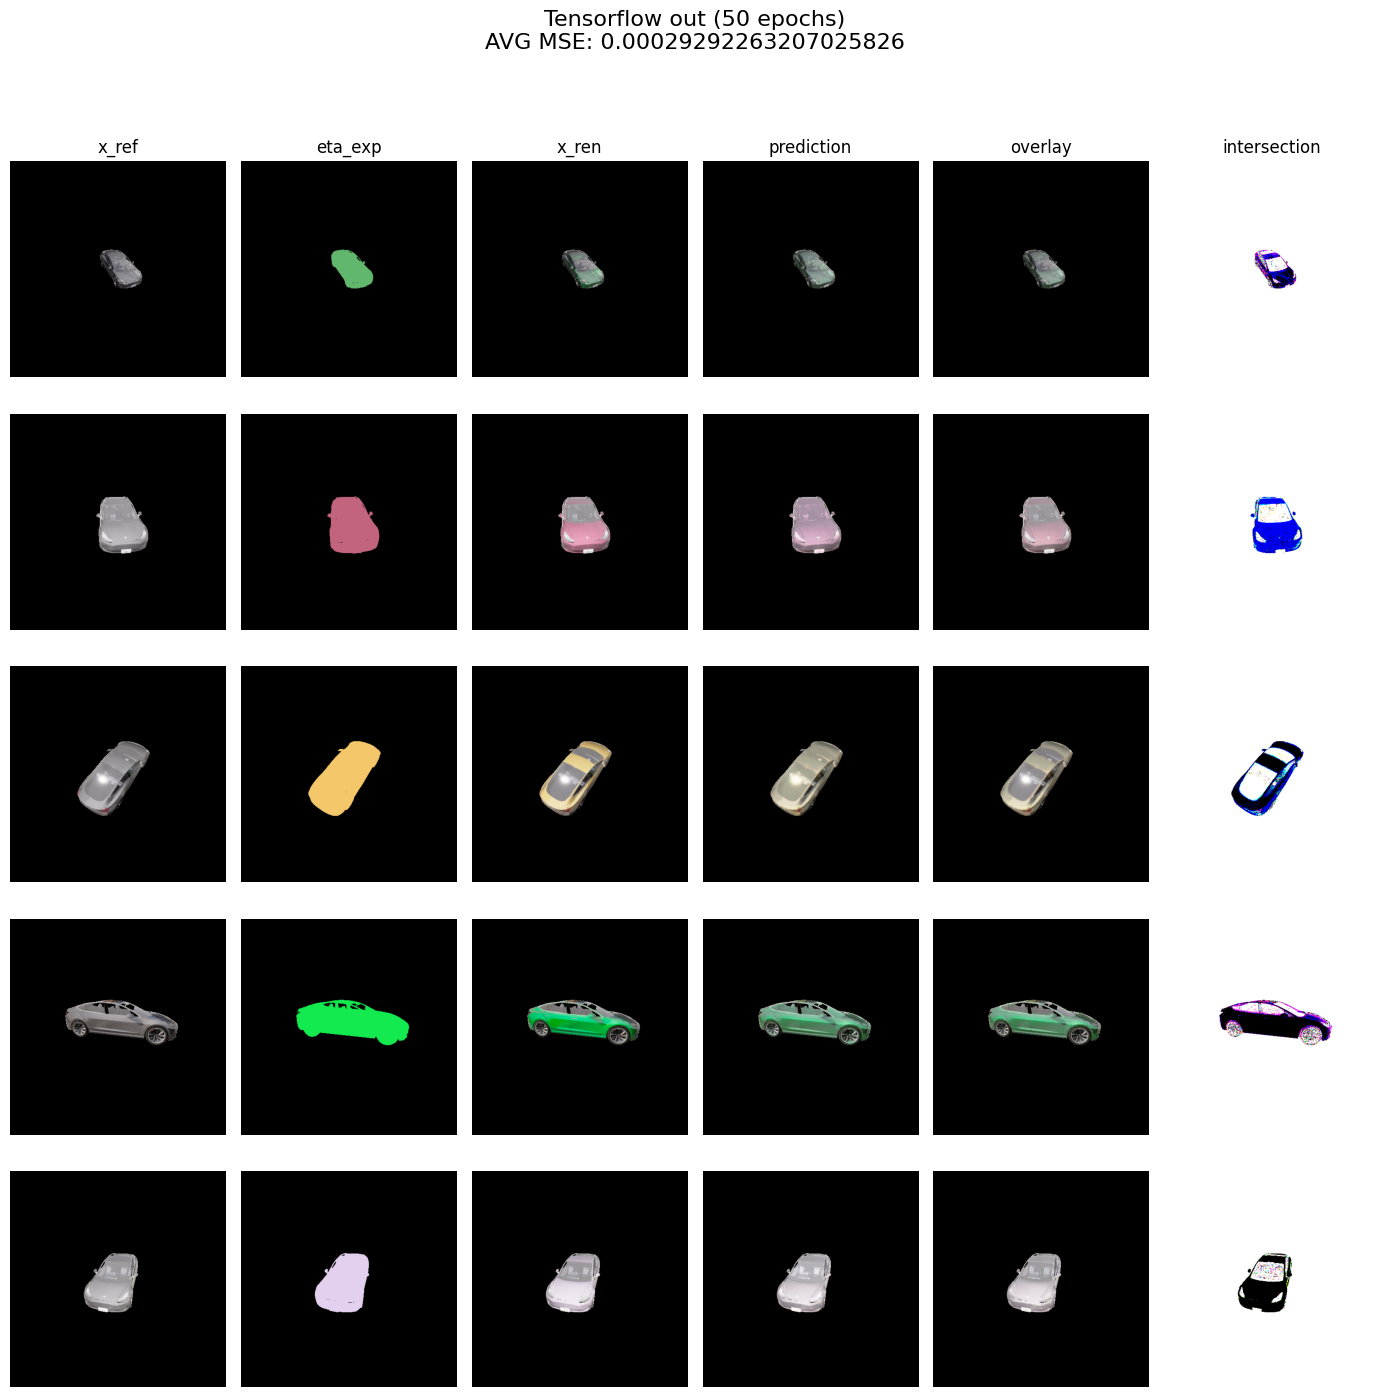

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Predict
preds = model.predict([x_ref[1025:], eta_exp[1025:]])

intersection_mask = np.isclose(x_ren[1025:], x_ref[1025:], atol=1e-2)
overlay_preds = np.where(intersection_mask, x_ref[1025:], preds)

num_samples = 5
titles = ["x_ref", "eta_exp", "x_ren", "prediction", "overlay", "intersection"]

plt.figure(figsize=(14, num_samples * 3))

for i in range(num_samples):
    images = [
        x_ref[i+1025],
        eta_exp[i+1025],
        x_ren[i+1025],
        preds[i],
        overlay_preds[i],
        intersection_mask[i].astype(float)  # Show mask as image
    ]
    for j in range(6):
        plt.subplot(num_samples, 6, i * 6 + j + 1)
        plt.imshow(np.clip(images[j], 0, 1), cmap='gray' if j == 5 else None)
        plt.axis('off')
        if i == 0:
            plt.title(titles[j])

plt.suptitle(f"Tensorflow out (50 epochs)\nAVG MSE: {avg_mse}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()